In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
#import matplotlib


import matplotlib.pylab as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

import tensorflow_hub as hub
import numpy as np
import pandas as pd
import argparse
import cv2
import argparse
import random
import pickle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [3]:
!pip install q keras==2.3.0
import keras
keras.__version__

     |████████████████████████████████| 378kB 6.6MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


Using TensorFlow backend.


'2.3.0'

In [0]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [0]:
def build_unsupervised_dataset(data, labels, validLabel=1,
	anomalyLabel=3, contam=0.01, seed=42):
	# grab all indexes of the supplied class label that are *truly*
	# that particular label, then grab the indexes of the image
	# labels that will serve as our "anomalies"
	validIdxs = np.where(labels == validLabel)[0]
	anomalyIdxs = np.where(labels == anomalyLabel)[0]

	# randomly shuffle both sets of indexes
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)

	# compute the total number of anomaly data points to select
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]
	print('total Anomaly data to be counted in model building: ', i)
  
	# use NumPy array indexing to extract both the valid images and
	# "anomlay" images
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]

	# stack the valid images and anomaly images together to form a
	# single data matrix and then shuffle the rows
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)

	# return the set of images
	return images

In [0]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

In [8]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [12]:
unique, counts = np.unique(trainY, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5923],
       [   1, 6742],
       [   2, 5958],
       [   3, 6131],
       [   4, 5842],
       [   5, 5421],
       [   6, 5918],
       [   7, 6265],
       [   8, 5851],
       [   9, 5949]])

In [15]:
print("[INFO] creating unsupervised dataset...")

# Here images of '1' are considered good images and images of '3' are considered anomaly images 
images = build_unsupervised_dataset(trainX, trainY, validLabel=1,
	anomalyLabel=3, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

[INFO] creating unsupervised dataset...
total Anomaly data to be counted in model building:  67


In [0]:
(trainX, testX) = train_test_split(images, test_size=0.2,
	random_state=42)

In [0]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32

In [18]:
# construct our convolutional autoencoder

print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...


In [19]:
# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

Epoch 1/10
171/171 [==============================] - 12s 69ms/step - loss: 0.0458 - val_loss: 0.0424
Epoch 2/10
171/171 [==============================] - 11s 67ms/step - loss: 0.0108 - val_loss: 0.0313
Epoch 3/10
171/171 [==============================] - 11s 66ms/step - loss: 0.0040 - val_loss: 0.0098
Epoch 4/10
171/171 [==============================] - 11s 67ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 5/10
171/171 [==============================] - 11s 67ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/10
171/171 [==============================] - 11s 67ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/10
171/171 [==============================] - 11s 66ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 8/10
171/171 [==============================] - 11s 67ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 9/10
171/171 [==============================] - 11s 67ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 10/10
171/171 [==============================] - 11s 67ms/step - loss: 0.002

In [21]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite("vis.png", vis)

[INFO] making predictions...


True

In [0]:
# loop over all original images and their corresponding
# reconstructions

errors = []
for (image, recon) in zip(testX, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

In [23]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.99)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 0.022517532538622764
[INFO] 14 outliers found


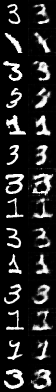

In [27]:
# initialize the outputs array
from google.colab.patches import cv2_imshow
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (testX[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# show the output visualization
cv2_imshow(outputs)
#cv2.waitKey(0)